In [1]:
import pymc3 as pm 
import numpy as np
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
import arviz as az

In [2]:
# To insure the PyMC3 is working on the same set of data as in R, 
#   rpy2, an inference to R in Python, is implementned.
data = robjects.r("""
set.seed(42) 
N <- 20 
true_lam <- 3
true_tau2 <- 1.5 
true_sig2 <- 1.2
true_mu <-true_lam + sqrt(true_tau2)*rnorm(N) 
y <- true_mu + sqrt(true_sig2)*rnorm(N)
""")
#  The true parameters are given as: 
N = 20
true_lam = 3
true_tau2 = 1.5 
true_sig2 = 1.2
y = data
nsamples = 1e4

In [3]:
y

4.343169,0.357063,3.256414,...,-1.185603,-2.633581,4.656372


In [23]:
# Building the model:
#   pm.Model() creates a new Model object, the subsequent specification of the model components 
# is performed inside a `with` statement until the indented block ends.
with pm.Model() as hnm_mod:  

  # hyper-priors:
  lam_tilde = pm.Normal('lambda_tilde', mu=0, sigma=1)
  lam = pm.Deterministic('lambda', 10 * lam_tilde)
  tau_sq = pm.InverseGamma('tau_sq', alpha= 1.0 , beta= 1.0, transform=None)
  # prior:
  sigma_sq = pm.InverseGamma('sigma_sq', alpha=1.0, beta=1.0, transform=None)
  # Likelihood:
  y_sd = pm.Deterministic('y_sd', np.sqrt(sigma_sq + tau_sq))
  L = pm.Normal('Likelihood', lam, sigma= y_sd, observed=y)


In [25]:
# Model Fitting

with hnm_mod:
  trace_hnm = pm.sample(draws= nsamples/2, tune=nsamples/2, target_accept=0.99, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma_sq, tau_sq, lambda_tilde]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 227 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
#  ArviZ packages methods will be used for plotting

In [ ]:
# Traceplot:
# `pm.traceplot` will generate trace plot for selected parameters as well
with hnm_mod:
  az.plot_trace(trace_hnm, var_names = ["lambda", "tau_sq", "sigma_sq"], legend=True)
  plt.show()

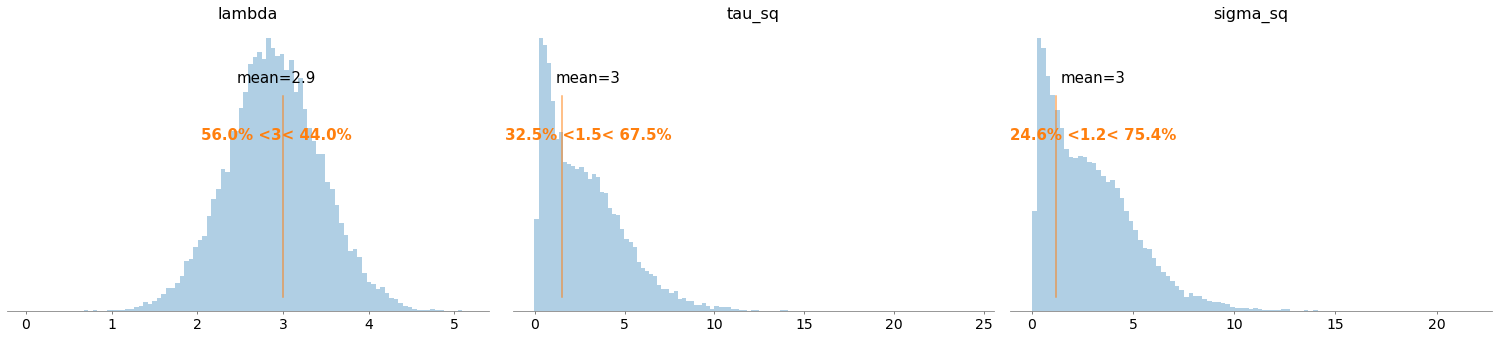

In [20]:
# Posterior plot:
# `pm.plot_posterior() will generate posterior plot as well:
with hnm_mod:
  az.plot_posterior(trace_hnm, var_names = ["lambda", "tau_sq", "sigma_sq"], kind='hist', point_estimate='mean', 
    ref_val=[true_lam, true_tau2, true_sig2], hdi_prob='hide', credible_interval=None)
  plt.show()